In [ ]:
!git clone --branch Env-Branch https://github.com/kp425/RL.git

fatal: destination path 'RL' already exists and is not an empty directory.


In [ ]:
from RL.policies.Policies import make_policy, BoltzmannPolicy, GaussianPolicy

In [ ]:
import numpy as np
from multiprocessing import Process, Pipe
from collections import deque
import gym
from gym import spaces
import cv2

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

        
class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, normalize= True,dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        self._normalize = normalize
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs



class VecFrameStack(VecEnv):
    def __init__(self, venv, nstack):
        self.venv = venv
        self.nstack = nstack
        wos = venv.observation_space  # wrapped ob space
        low = np.repeat(wos.low, self.nstack, axis=-1)
        high = np.repeat(wos.high, self.nstack, axis=-1)
        self.stackedobs = np.zeros((venv.num_envs,) + low.shape, low.dtype)
        observation_space = spaces.Box(low=low, high=high, dtype=venv.observation_space.dtype)
        action_space = venv.action_space
        VecEnv.__init__(self, venv, observation_space=observation_space, action_space = action_space)

    def step_wait(self):
        obs, rews, news, infos = self.venv.step_wait()
        self.stackedobs = np.roll(self.stackedobs, shift=-1, axis=-1)
        for (i, new) in enumerate(news):
            if new:
                self.stackedobs[i] = 0
        self.stackedobs[..., -obs.shape[-1]:] = obs
        return self.stackedobs, rews, news, infos

    def reset(self):
        obs = self.venv.reset()
        self.stackedobs[...] = 0
        self.stackedobs[..., -obs.shape[-1]:] = obs
        return self.stackedobs




def tile_images(img_nhwc):
    """
    Tile N images into one big PxQ image
    (P,Q) are chosen to be as close as possible, and if N
    is square, then P=Q.
    input: img_nhwc, list or array of images, ndim=4 once turned into array
        n = batch index, h = height, w = width, c = channel
    returns:
        bigim_HWc, ndarray with ndim=3
    """
    img_nhwc = np.asarray(img_nhwc)
    N, h, w, c = img_nhwc.shape
    H = int(np.ceil(np.sqrt(N)))
    W = int(np.ceil(float(N)/H))
    img_nhwc = np.array(list(img_nhwc) + [img_nhwc[0]*0 for _ in range(N, H*W)])
    img_HWhwc = img_nhwc.reshape(H, W, h, w, c)
    img_HhWwc = img_HWhwc.transpose(0, 2, 1, 3, 4)
    img_Hh_Ww_c = img_HhWwc.reshape(H*h, W*w, c)
    return img_Hh_Ww_c

def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

def make_atari_env(env_name, width = 84, height = 84, grayscale = True):
    def _thunk():
        env = gym.make(env_name)
        env = WarpFrame(env, width = width, height = height, grayscale = grayscale)
        return env
    return _thunk

In [ ]:


# data = tile_images(env.reset())

# print(data.shape)

# plt.imshow(data, interpolation='nearest')
# plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, Sequential
import tensorflow_probability as tfp

def conv_net(input_shape, n_outputs):

    inputs = Input(shape = input_shape)

    hidden_layers = [layers.Conv2D(32, (3, 3), activation='relu'),
                     layers.MaxPooling2D((2, 2)),
                     layers.Flatten()]
    h_inputs = inputs
    for h_layer in hidden_layers:
        h_inputs = h_layer(h_inputs)

    # policy_layers = [layers.Dense(64, activation='relu')]
    policy_layers = []

    p_inputs = h_inputs
    for p_layer in policy_layers:
        p_inputs = p_layer(p_inputs)

    # value_layers = [layers.Dense(64, activation = tf.nn.relu, name = "value_layers")]
    value_layers = []
    v_inputs = h_inputs
    for v_layer in value_layers:
        v_inputs = v_layer(v_inputs)

    policy_head = layers.Dense(n_outputs, activation = tf.nn.softmax, name = "policy_head")(p_inputs) 
    value_head = layers.Dense(1, activation = tf.nn.tanh, name = "value_head")(v_inputs)
    model = Model(inputs = [inputs], outputs = [policy_head, value_head])

    return model









In [ ]:
from matplotlib import pyplot as plt
env_name = "Assault-v0"
num_envs = 4
envs = [make_env(env_name) for i in range(num_envs)]
env = SubprocVecEnv(envs)
# env  = VecFrameStack(env, 4)


model = make_policy(env.observation_space, env.action_space, net = conv_net)



gamma = 0.99
smoothing_factor = 0.95

def compute_returns_with_gae(next_state, rewards, values, masks):
    returns = []
    values = values + [np.squeeze(model(next_state)[2])] # we do this to avoid index out of error
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = (rewards[i] + gamma* values[i+1]* masks[i]) - values[i]
        gae = delta + gamma * smoothing_factor * gae * masks[i]
        returns.insert(0, gae + values[i])
    return returns

def ppo_collect(sample_size = 50, gamma = gamma, smoothing_factor = smoothing_factor):
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []

    state = env.reset()  # Try resetting to random observation
    for _ in range(sample_size):

        action, dist, value = model(state)
        log_prob = dist.log_prob(action)
        print(action.numpy())
        next_state, reward, done, _ = env.step(action.numpy())
      
  
        log_probs.append(log_prob)
        values.append(np.squeeze(value))
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        masks.append(1.0-done)
        state = next_state

    returns = compute_returns_with_gae(next_state, rewards, values, masks)
    
    states = tf.concat(states, axis = 0)
    actions = tf.squeeze(tf.concat(actions, axis = 0))
    log_probs = tf.squeeze(tf.concat(log_probs, axis = 0))
    values = tf.concat(values, axis = 0)
    returns = tf.cast(tf.concat(returns, axis = 0), dtype = tf.float32)
    advantages = tf.math.subtract(returns, values)
  
    n = sample_size * num_envs

    tf.debugging.assert_shapes([(states, (n, * env.observation_space.shape)),
                                (actions, (n,)),
                                (log_probs, (n,)),
                                (values, (n,)),
                                (returns, (n,)),
                                (advantages, (n,))])

    # tf.debugging.assert_shapes([(states, (n, None)),
    #                             (actions, (n,)),
    #                             (log_probs, (n,)),
    #                             (values, (n,)),
    #                             (returns, (n,)),
    #                             (advantages, (n,))])
    
    return states, actions, log_probs, values, returns, advantages



k = ppo_collect()

print(k[0].shape)




(4, 250, 160, 12)
(250, 160, 12)


TypeError: ignored

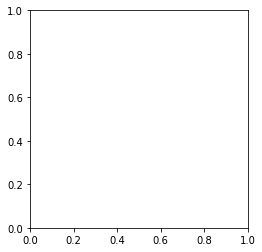

In [ ]:
env_name = "Assault-v0"
num_envs = 4
envs = [make_env(env_name) for i in range(num_envs)]
env = SubprocVecEnv(envs)
env  = VecFrameStack(env, 4)

state = env.reset()
print(state.shape)

# data = tile_images(state)

# print(data.shape)

for batch in state:
    for idx, row in enumerate(batch):
        if (idx+1)%3 == 0:
            
    plt.imshow(i, interpolation='nearest')
    plt.show()



In [ ]:
env_name = "Assault-v0"
nenvs = 8
envs = [make_atari(env_name) for i in range(nenvs)]
env = SubprocVecEnv(envs)
env = wrap_deepmind(env, frame_stack = True, scale = True)


print(env.observation_space)

print(env.action_space)
